In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.datasets import load_wine, load_breast_cancer
import wget
import os
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Classification Model Evaluation

When we build a classification model, evaluating the performance is different, and often more complex, than when using a regression model. 

### Data Exploration

Our data here is on wine. The features are a bunch of chemical properties of the wine that could be taken in a lab. The target is a quality indicator - 0 is poor, 1 is good. Our goal is to make a model that can split the wine into good and not good, using the chemical properties as input.

In [2]:
# Load the diabetes dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df.drop(["mean fractal dimension", "worst fractal dimension", "texture error", 
         "smoothness error", "symmetry error", "fractal dimension error", 
         "concavity error", "compactness error", "concave points error",
         "perimeter error", "area error", "worst texture", "worst smoothness",
         "worst symmetry", "worst compactness", "worst concavity", "worst concave points"
         ], axis=1, inplace=True)
targ = pd.Series(data.target)

df["target"] = targ
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,radius error,worst radius,worst perimeter,worst area,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,1.0950,25.38,184.60,2019.0,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.5435,24.99,158.80,1956.0,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.7456,23.57,152.50,1709.0,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.4956,14.91,98.87,567.7,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.7572,22.54,152.20,1575.0,0


#### Sample the Data

We'll look at sampling later, but we can introduce it now. Our pairplots can often be slow, so we can use the sample function to randomly select some subset of the data to plot. 

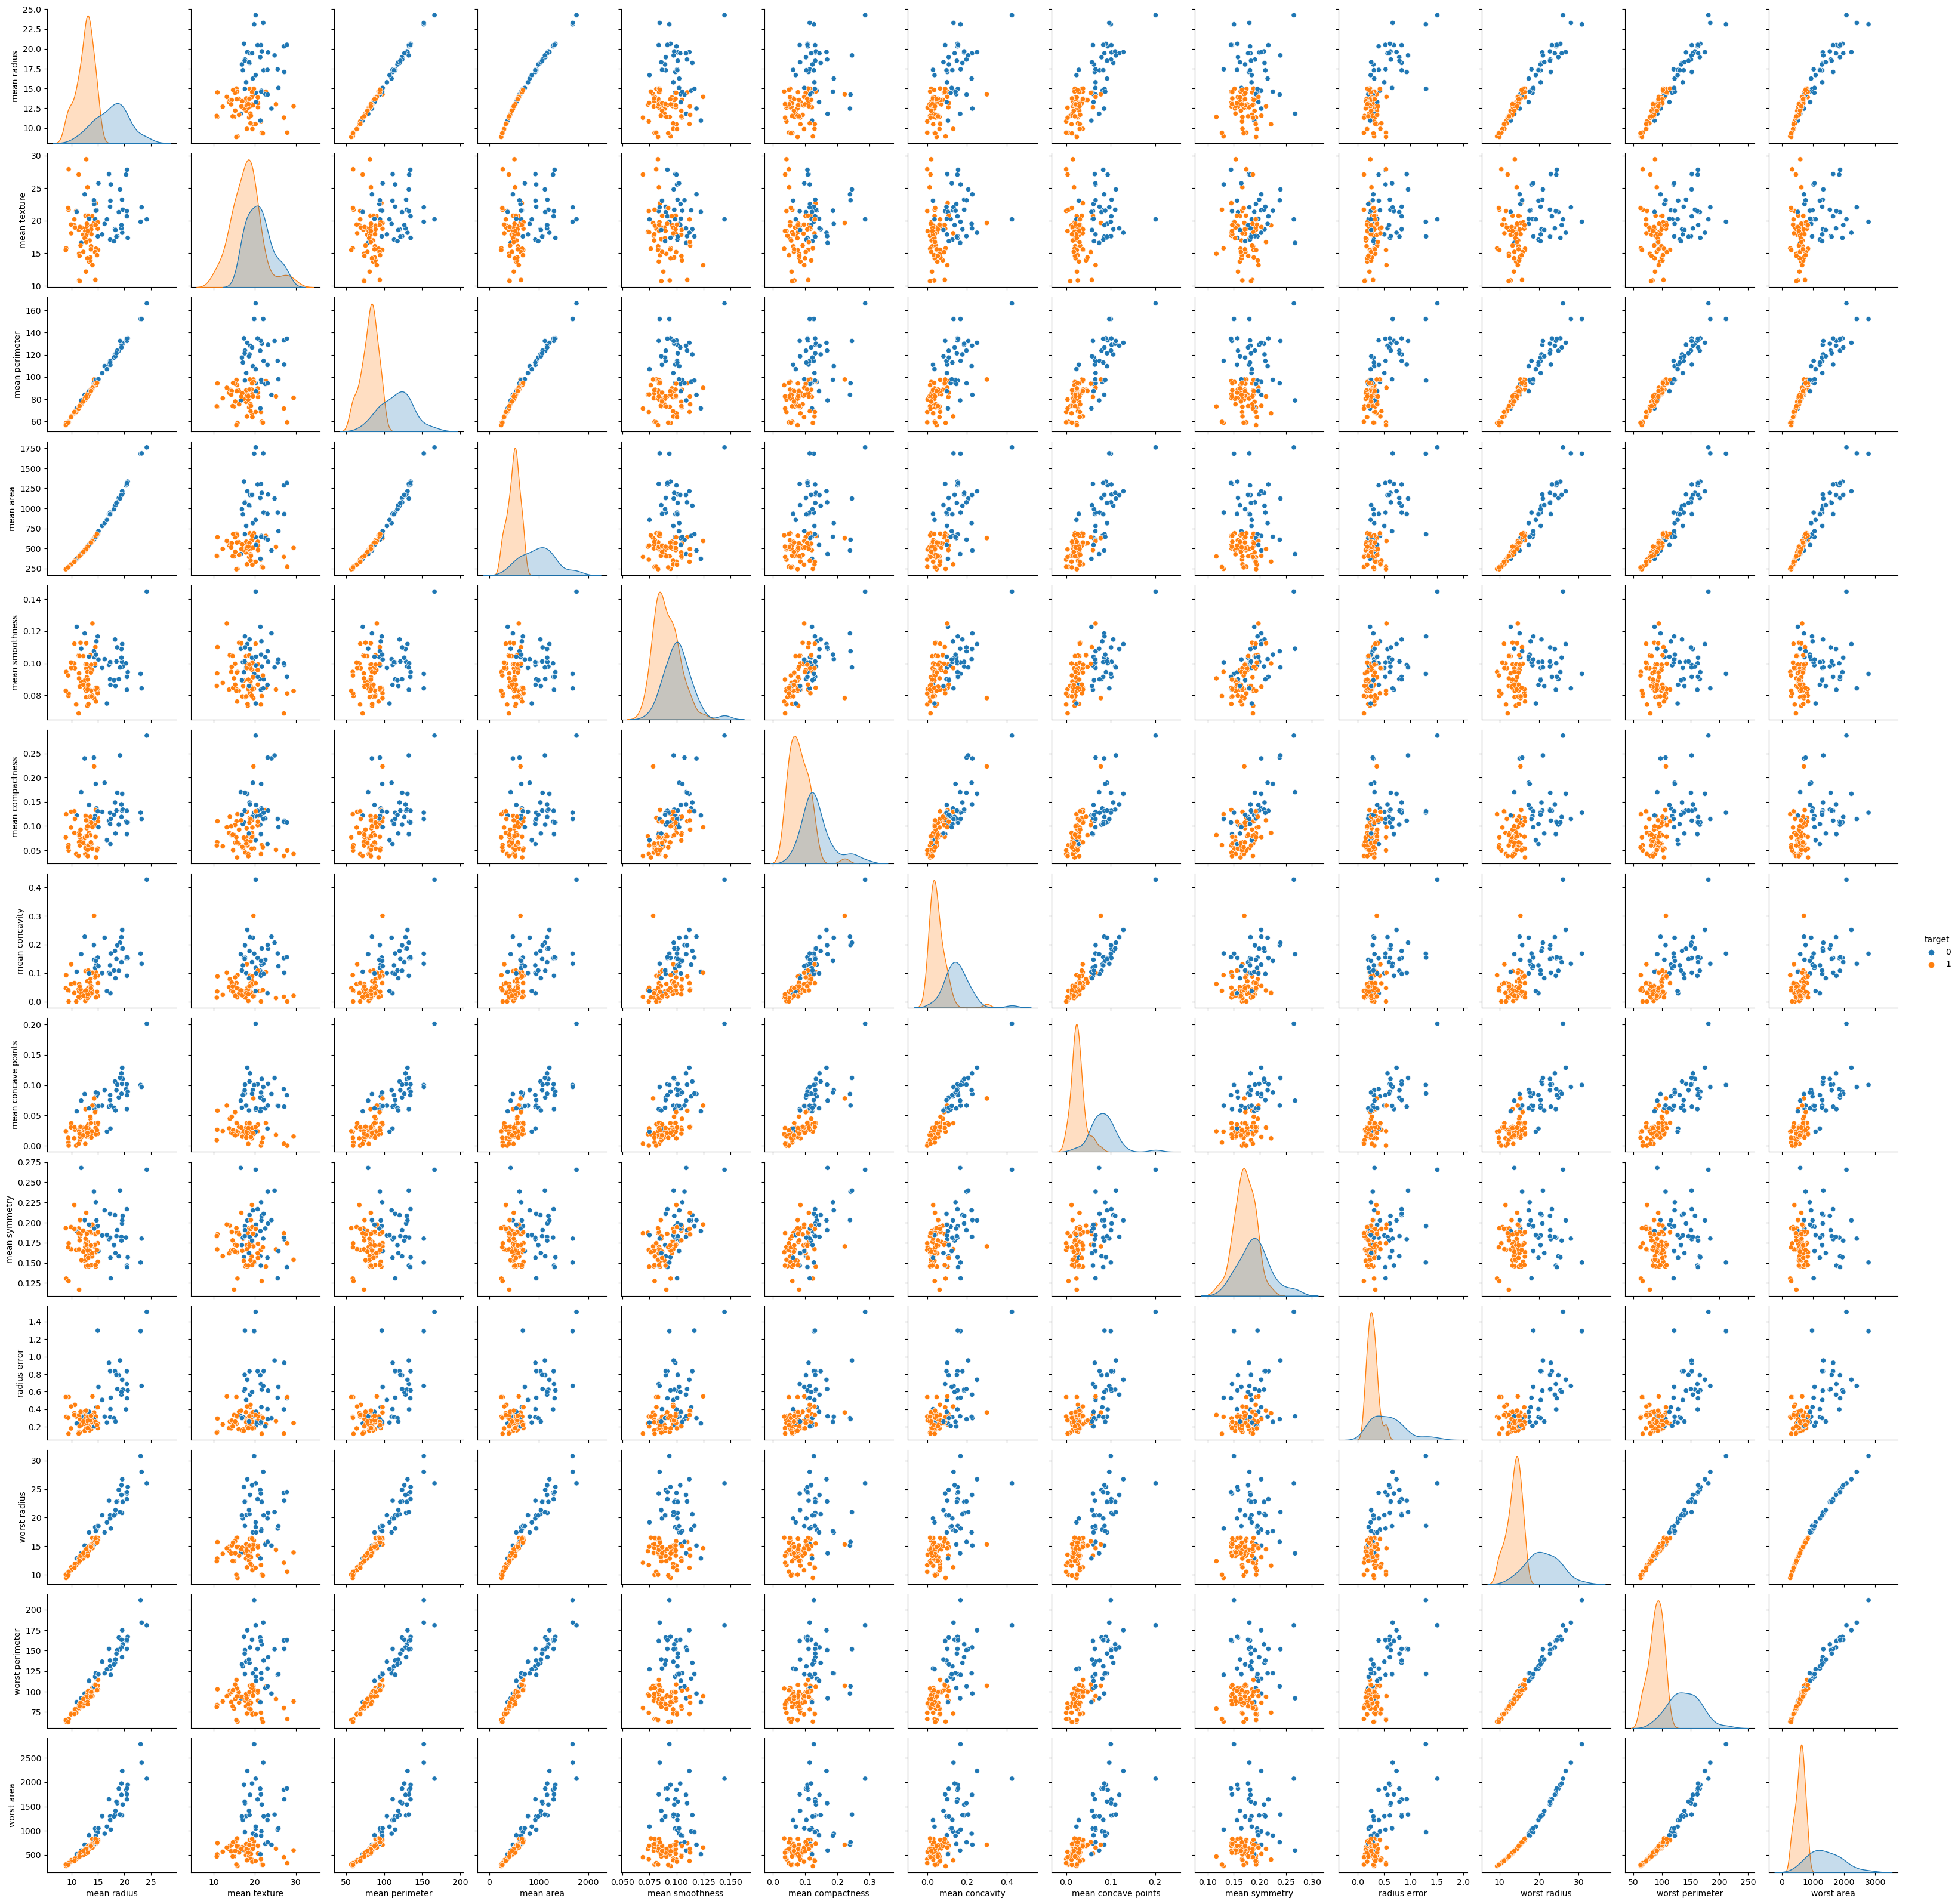

In [3]:
samp_size = 100
sns.pairplot(df.sample(samp_size), hue="target")

In [4]:
df["target"].value_counts()

1    357
0    212
Name: target, dtype: int64

### Baseline Accuracy

When we have imbalanced classes, we need to be careful when using accuracy as a metric. For example, if we have a dataset where 95% of the instances are in class A and 5% are in class B, a model that always predicts class A will have an accuracy of 95%. This is why we need to look at the confusion matrix and other metrics to evaluate the model's performance.

If we can't beat a simple baseline model, then we need to re-evaluate our approach, so this is a good starting point to figure out a... baseline.

#### Sample Baseline

We can just calculate the percentage of the majority class and use that as our baseline. This is a simple way to get a baseline accuracy. If a dumb model just predicted "1" every time, it would get this accuracy on our test data. 

In [5]:
baseline = df["target"].sum() / len(df["target"])
baseline

0.6274165202108963

### Create Model

We can first create a model, and see how good it is. 

In [6]:
model_1 = LogisticRegression()
X = df.drop(columns="target")
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe_1 = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("model", model_1)
])

pipe_1.fit(X_train, y_train)

print("Training model 1 accuracy: ", pipe_1.score(X_train, y_train))
print("Testing model 1 accuracy: ", pipe_1.score(X_test, y_test))

Training model 1 accuracy:  0.9362637362637363
Testing model 1 accuracy:  0.956140350877193


#### Comparison Model

Just for fun, we'll compare our logistic regression model to another type of model, one called a Support Vector Machine. We don't need to worry about the details of this for now, but this is just a different common type of model. One thing that is important is that there is a hyperparameter of kernel='sigmoid' that is fed to the model. This controls the types of relationships (linear, polynomial, etc.) that the model fits well to. This model is not well fitted to linear relationships, which is why the performance is bad. 

In [7]:
from sklearn.svm import SVC

model_2 = SVC(kernel="sigmoid")

pipe_2 = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("model", model_2)
])

pipe_2.fit(X_train, y_train)

print("Training model 2 accuracy: ", pipe_2.score(X_train, y_train))
print("Testing model 2 accuracy: ", pipe_2.score(X_test, y_test))

Training model 2 accuracy:  0.2879120879120879
Testing model 2 accuracy:  0.32456140350877194


### Fit and Initial Findings

We can look at the results of the trial models above, along with the exploration of the data, to see if we can make any initial conclusions to guide our progress. So what have we seen to this point?

<b>Try to think before scrolling down!</b>


<b>Initial Findings:</b>
<ul>
<li> A default linear regression model acheives very good accuracy. </li>
<li> The other model, which is not well suited to linear relationships, does not perform well. </li>
<li> In the pairplot's scatter plots, it looks like we can separate the classes with a line pretty well in most cases. </li>
<li> In the pairplot's histograms, there are several features that look like they are excellent in separating the classes, just by looking at the difference in distribution of the classes. </li>
<li> 

So at this point, I know that:
<ul>
<li> A model that is linear, like a Logistic Regression, is likely a good choice for this data. </li>
<li> There are some features that look to be excellent at divding the classes. I will likely consider trying to make a model with a subset of these "great" features and see if that performs well despite being similar. </li>
    <ul>
    <li> This data is real, and if we are able to accurately predict with fewer measurements, that's a win. </li>
    </ul>
<li> We porbably have more concern about a false negative than a false positive, given the impacts. </li>
</ul>

## Accuracy

The most basic metric for evaluating a classification model is accuracy. This is the proportion of correctly classified instances out of the total instances. Accuracy is the default metric for the score() function when called with a classification model in scikit-learn.

### Confusion Matrix

The confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known.

![Confusion Matrix](../images/confusion.png "Confusion Matrix")

We can get the values for a confusion matrix using the confusion_matrix() function from scikit-learn, if we provide any model's predictions and the true values. This output can then be fed directly into a sns.heatmap() plot to make the pretty picture we see below. The individual values can also be extracted, if you need to use them or present them in another way - the confusion matrix is just a 2x2 array of numbers, so we can just point to the correct cells:
<ul>
    <li>True Positives: 1,1</li>
    <li>False Positives: 0,1</li>
    <li>False Negatives: 1,0</li>
    <li>True Negatives: 0,0</li>
</ul>

<b>Note:</b> the confusion matrix is not guaranteed to be oriented in the same way, the axes or the order could be flipped. Sklearn's confusion matrices should be consistent, but others may vary. 

### Error Types

The confusion matrix gives a clear visual example of a simple concept - we can be wrong in two totally different ways. We can predict a positive when it's actually negative, or we can predict a negative when it's actually positive. These are the two types of errors we can make, and they have different implications. Each type of error has a name:

<ul>
    <li>False Positive: We predicted positive, but it was actually negative. This is also known as a "Type I Error".</li>
    <li>False Negative: We predicted negative, but it was actually positive. This is also known as a "Type II Error".</li>
</ul>

In some cases, an error is an error; in other cases, it can be life and death. 

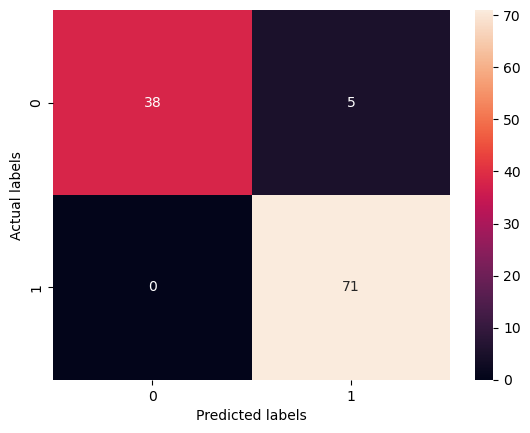

In [8]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, pipe_1.predict(X_test))

# Create the heatmap
ax = sns.heatmap(cm, annot=True, fmt="d")

# Set the labels
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')

# Display the plot
plt.show()

#### Compare to Model #2. 

We can look at the performance of the model and compare it to a second model. This model has very different performance, so we see very different results on the confusion matrix.

<b>Note:</b> this model is a different type of model, that works totally differently to a logistic regression model. The performance here indicates that this model is a 'poor fit' for the data. In a normal comparison, we'd likely ditch this model entirely, and try to make improvements to the logistic regression model. This specific 'miss' is dramatic, but a similar effect is seen frequently - some models fit some data better than others.

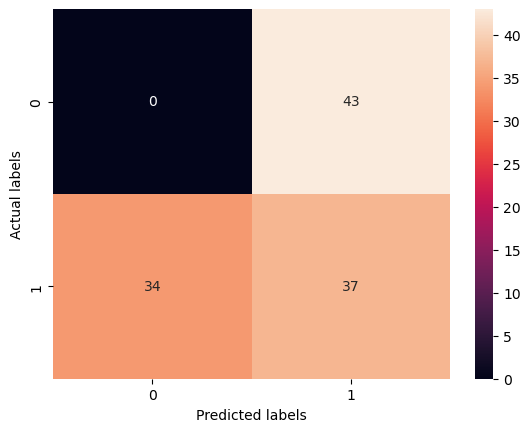

In [9]:
cm_2 = confusion_matrix(y_test, pipe_2.predict(X_test))

# Create the heatmap
ax = sns.heatmap(cm_2, annot=True, fmt="d")

# Set the labels
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')

# Display the plot
plt.show()

## Precision and Recall

When we are doing classifications we often have scenarios where getting a false negative or a false positive may not have the same impact. For example, if we have a model that is detecting cancer from a medical image, we would want to minimize the number of false negatives (i.e. we don't want to miss a cancer diagnosis). On the other hand, if we have a model that is detecting spam emails, we would want to minimize the number of false positives (i.e. we don't want to mark a legitimate email as spam). For scenarios like these, we can use alternative metrics to evaluate the model's performance, depending on what we value. 

![Accuracy Metrics](../images/accuracy_calculations.jpg "Accuracy Metrics")

### Recall

Recall is the proportion of actual positive cases that were correctly identified. We normally look at recall when we want to minimize false negatives. For example, if we have a model that takes in medical images and predicts whether a patient has cancer or not, we would want to minimize the number of false negatives.

<b>Note:</b> Recall is also known as "sensitivity" or "true positive rate".

### Precision

Precision is the proportion of positive identifications that were actually correct. We normally look at precision when we want to minimize false positives. For example, if we have a model that detects spam emails, we would want to minimize the number of false positives - or real emails being trash-canned.

In [10]:
recall_1 = recall_score(y_test, pipe_1.predict(X_test))
precision_1 = precision_score(y_test, pipe_1.predict(X_test))

print("Test Data Results for Model 1:")
print("Recall model 1: ", recall_1)
print("Precision model 1: ", precision_1)
print("Accuracy model 1: ", accuracy_score(y_test, pipe_1.predict(X_test)))


Test Data Results for Model 1:
Recall model 1:  1.0
Precision model 1:  0.9342105263157895
Accuracy model 1:  0.956140350877193


In [11]:
recall_2 = recall_score(y_test, pipe_2.predict(X_test))
precision_2 = precision_score(y_test, pipe_2.predict(X_test))

print("Test Data Results for Model 2:")
print("Recall model 2: ", recall_2)
print("Precision model 2: ", precision_2)
print("Accuracy model 2: ", accuracy_score(y_test, pipe_2.predict(X_test)))

Test Data Results for Model 2:
Recall model 2:  0.5211267605633803
Precision model 2:  0.4625
Accuracy model 2:  0.32456140350877194


## F1 Score

The F1 score is the harmonic mean of precision and recall. The harmonic mean is used because it is the most appropriate average when dealing with rates. The equation for the F1 score is:

$ F1 = 2 * \frac{precision * recall}{precision + recall} $

The F1 score is a good way to evaluate a model when we want to balance precision and recall. It is a good way to compare models when we want to minimize both false positives and false negatives. In practice, F1 is often used when the True class is comparatively rare, and when that True class is the focus, such as fraud and medical diagnoses.

In [12]:
f1_1 = f1_score(y_test, pipe_1.predict(X_test))
print("F1 Score model 1: ", f1_1)

F1 Score model 1:  0.9659863945578232


In [13]:
f1_2 = f1_score(y_test, pipe_2.predict(X_test))
print("F1 Score model 2: ", f1_2)

F1 Score model 2:  0.4900662251655629


## ROC Curve

<b>Note:</b> the details of this are a bit beyond our scope, this is a good thing to be aware of, but we will not be delving into the details. 

The ROC curve is a graphical representation of the true positive rate (recall) against the false positive rate. It shows the tradeoff between sensitivity and specificity. The area under the curve (AUC) is a measure of how well the model is able to distinguish between classes. The higher the AUC, the better the model is at predicting the target class.

![ROC Curve](../images/roc.png "ROC Curve")

We can think of the ROC curve roughly as a tradeoff, or a race, between the true positive rate and the false positive rate. The ideal model would have a true positive rate of 1 and a false positive rate of 0, which would put it in the top left corner of the plot. The worst model would have a true positive rate of 0 and a false positive rate of 1, which would put it in the bottom right corner of the plot. The closer the curve is to the top left corner, the better the model is at distinguishing between the two classes. In a sense, the farther the line goes up, before it goes right, means that the model is making more correct predictions for each incorrect prediction it makes. 

Generating an ROC curve requires a few steps. These are not things that you'll need to reproduce, but we do see them relatively frequently. The basic outline of the code is reusable by just swapping out the model and the data.

### AUC

The AUC is the area under the ROC curve, or the integral. It is a single scalar value that represents the "average" performance of the model across all possible classification thresholds. The AUC is a useful metric for imbalanced classes, as it gives us a single number that represents the model's ability to distinguish between the two classes. We can get the AUC score directly using the roc_auc_score() function from scikit-learn. 

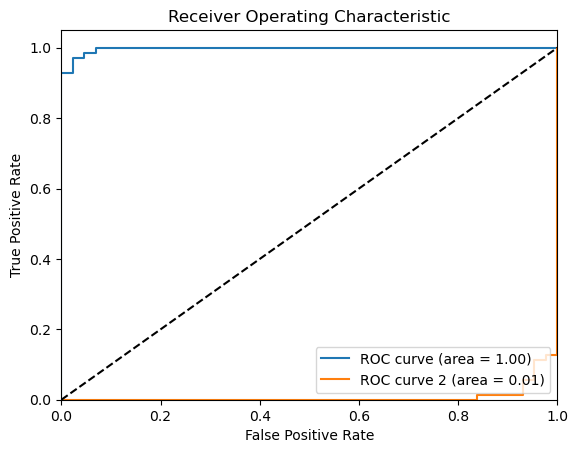

In [14]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class
y_pred_prob = pipe_1.predict_proba(X_test)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
fpr2, tpr2, thresholds2 = roc_curve(y_test, pipe_2.decision_function(X_test))

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, label='ROC curve 2 (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Choosing a Metric

When evaluating a classification model we generally need some domain knowledge to choose the most appropriate metric. We can start with accuracy as a baseline, then look at the confusion matrix to see if there are any patterns in the errors. Depending on what our real-world goal and scenario of use for the model is, we can pick something other than accuracy if that makes the most sense for our application.

So, as a rough guideline we can use the following:
<ul>
    <li>Accuracy: When the cost of false positives and false negatives are similar</li>
    <li>Precision: When the cost of false positives is high</li>
    <li>Recall: When the cost of false negatives is high</li>
    <li>F1 Score: When we want to balance precision and recall - i.e. raw accuracy isn't good enough, the F1 score will help us not have a model that is too bised to either precision or recall.</li>
    <li>Something Else: If we have more specific concerns due to the nature of our problem, that might guide our decision making. </li>
</ul>

In our example cases, we'll normally rely on accuracy. In real applications, we normally need to consider the real world implications of both our model's overall performance and the specific types of errors it makes. Things like missing when attempting to predict which Costco customers to send a coupon to are expected and not a big deal; missing when attempting to predict if an earthquake will flatten a new bridge you're designing is catastrophic. Often times there are costs and benefits associated to a different distribution of a model's errors, and to make a good decision we need to combine those impacts with the raw percentages that we get from our model's reporting. 

We will soon look at tools we can use to help test and compare models and options in a more systematic way, but for now we can just try, observe, and select the best option. 

## Exercise

Predict the target, and evaluate the model using the accuracy, precision, recall, F1 score, and AUC.

In [15]:
from sklearn.datasets import make_classification

test_data = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42, class_sep=0.5)
df_test_data = pd.DataFrame(test_data[0])
df_test_data["target"] = test_data[1]
df_test_data.head()

,0,1,2,3,4,5,6,7,8,9,target
0,0.950513,-0.066449,0.816279,-0.358079,0.997266,1.181890,-1.115679,-1.210161,-1.128077,1.227274,0
1,-0.902225,-0.566395,-0.838125,0.831617,-1.176962,1.820544,1.252375,-0.984534,0.863896,0.209470,1
2,-0.095198,-0.432774,-0.287160,0.793818,-0.268646,-1.836360,0.739086,-0.246383,-0.558145,-0.297376,1
3,1.326707,2.023606,1.323417,0.006800,-1.607661,0.184741,-2.119427,-0.357445,-0.973127,-0.190039,0
4,0.198979,-0.711303,0.143965,0.117124,1.536061,0.597538,-0.151355,-0.939156,-0.324085,0.236224,1


## Imbalanced Classes

One place where these ideas come up frequently is with imbalanced data, which is data where the classification target values have a large skew towards True or False. For example, if we are trying to predict credit card fraud (which transactions are legit and which are fraudulent), we might have a dataset where 99.9% or more of the records in the data have a False value for the target. In this case, we might have a model that is 99.9% accurate, but it's not actually doing a good job of predicting the fraud cases. 

![Balanced](../images/balanced.png "Balanced") 

### Dealing with Imbalanced Classes

There are a few different ways that we can deal with imbalanced target classes. 

#### Different Metrics

We can use different metrics, like precision and recall, to evaluate the model's performance, instead of just the raw performance.

### Imbalanced Libraries

There are libraries that can help us deal with imbalanced classes, there is a library called imbalanced-learn that has a bunch of different tools and techniques that can help us deal with imbalanced classes.

In [16]:
filename = "creditcard.csv"
url = "https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/creditcard.csv"

if not os.path.isfile(filename):
    wget.download(url)

In [17]:
df_cc = pd.read_csv("creditcard.csv")
df_cc.drop("Time", axis=1, inplace=True)
cc_targ = "Class"
df_cc.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


##### Baseline Accuracy

We can calculate the baseline accuracy for a fraud prediction. 

In [18]:
baseline_cc = 1-(df_cc[cc_targ].sum() / len(df_cc[cc_targ]))
baseline_cc

0.9982725143693799

##### Print Helper Function

I have also declared a helper function to generate some of the scoring information for us, as programmers are lazy. 

In [19]:

def printAccuracies(pipe, train_X, train_y, test_X, test_y):
    pipe.fit(train_X, train_y)
    print("Training Results:")
    print("\tRecords: ", len(train_X))
    print("\tTrue Records: ", train_y.sum())
    print("\tFalse Records: ", len(train_y) - train_y.sum())

    print("\n")
    print("Testing Results:")
    print("\tRecords: ", len(test_X))
    print("\tTesting accuracy: {:.2%}".format(pipe.score(test_X, test_y)))
    print("\tTesting Precision: {:.2%}".format(precision_score(test_y, pipe.predict(test_X))))
    print("\tTesting Recall: {:.2%}".format(recall_score(test_y, pipe.predict(test_X))))
    print("\tTesting F1: {:.2%}".format(f1_score(test_y, pipe.predict(test_X))))
    print("\tTotal False Negatives: {:.0f}".format(len(test_y) * (1 - recall_score(test_y, pipe.predict(test_X)))))
    print("\tTotal False Positives: {:.0f}".format(len(test_y) * (1 - precision_score(test_y, pipe.predict(test_X)))))
    print("\tFalse Negative Rate: {:.2%}".format(1 - recall_score(test_y, pipe.predict(test_X))))
    print("\tFalse Positive Rate: {:.2%}".format(1 - precision_score(test_y, pipe.predict(test_X))))

    print("\nConfusion Matrix (Test Data):")
    ax = plt.subplot()
    sns.heatmap(confusion_matrix(test_y, pipe.predict(test_X)), annot=True, fmt="d", ax=ax, cmap="YlGnBu")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('Actual labels')
    ax.set_title('Confusion Matrix (Test Data)')
    plt.show()

##### Special Splitting

I am going to split the data in a weird way here, to make comparing the models easier. This is a one-off example, but I want to keep the identical test data for all the models, so I can compare them directly.

In [20]:
train_split = 0.8
df_cc_train = df_cc.sample(frac=train_split, replace=False)
df_cc_test = df_cc.drop(df_cc_train.index)

df_cc_test_X = df_cc_test.drop(cc_targ, axis=1)
df_cc_test_y = df_cc_test[cc_targ]

##### Baseline Real Model

We can also do a simple model here, to see what we get without doing anything to the data or the setup of the modelling. 

Training Results:
	Records:  227846
	True Records:  393
	False Records:  227453


Testing Results:
	Records:  56961
	Testing accuracy: 99.90%
	Testing Precision: 87.04%
	Testing Recall: 47.47%
	Testing F1: 61.44%
	Total False Negatives: 29919
	Total False Positives: 7384
	False Negative Rate: 52.53%
	False Positive Rate: 12.96%

Confusion Matrix (Test Data):


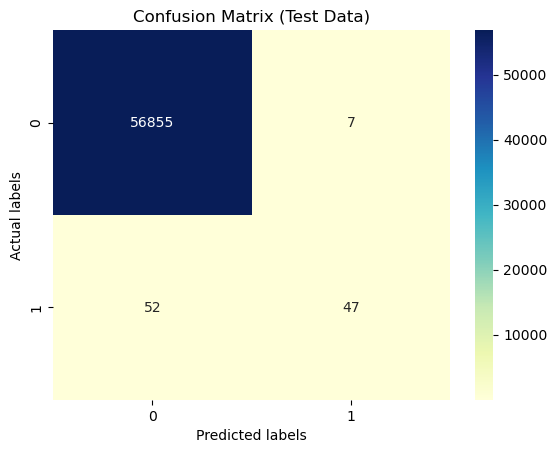

In [21]:
y_cc = df_cc_train[cc_targ]
X_cc = df_cc_train.drop(columns=cc_targ)

model_3 = LogisticRegression()
pipe_3 = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("model", model_3)
])

printAccuracies(pipe_3, X_cc, y_cc, df_cc_test_X, df_cc_test_y)

### Sampling

The most direct way to deal with imbalanced classes is to sample the data so that the classes are balanced, or closer to being balanced. This can be done by undersampling the majority class, oversampling the minority class, or using a combination of both.

<b>Note:</b> when dealing with imbalanced data we may be, consciously, changing the data we are using to train the model. This can seem odd, but remember that the goal is to get a model that makes useful predictions, not to create a model that is "pure" in some sense.

![Over and Under Sampling](../images/over_under.png "Over and Under Sampling")

#### Performing Resampling

There are many ways to implement resampling, and most 'real' applications will use some dedicated library such as imblearn. We can do a simple version manually to see the details - the sample() function in pandas will randomly select the specified number of records from the dataframe, which allows us to do undersampling. We can also do oversampling with sample by adding the "replace=True" argument, which allows us to sample the same record multiple times, so we can sample more records than we have in the original dataset.

Doing this is relatively simple, we just need to calculate the number of records that we want, then use the sample() function to create that number of rows from the original dataset. So the steps are:
<ol>
    <li> I'll label the class we are changing as the Object class, and the other as the Source class. </li>
    <li> Split the dataset into the Object and Source classes by dividing the data by the target value. </li>
    <li> Calculate the number of records in the Source class. </li>
    <li> Use the sample() function on the Object class with that numnber of records. Use the replace=True argument if oversampling. </li>
    <li> Concatenate the two datasets back together using pd.concat(). </li>
</ol>

#### Undersampling

The most simple thing that we can do is to just take a random sample of the majority class, so that we have a balanced dataset. This is a simple way to get a balanced dataset, but it can be a bit wasteful, as we are throwing away a lot of data.

In [22]:
fraud_len = len(df_cc_train[df_cc_train["Class"] == 1])
non_fraud = df_cc_train[df_cc_train["Class"] == 0].sample(fraud_len)

df_cc_balanced = pd.concat([df_cc_train[df_cc_train["Class"] == 1], non_fraud])

print("Counts:", df_cc_balanced["Class"].value_counts())
df_cc_balanced.head()

Counts: 1    393
0    393
Name: Class, dtype: int64


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
154720,-5.552122,5.678134,-9.775528,8.416295,-4.409844,-1.506235,-6.899839,3.750443,-3.879793,-6.864164,...,1.128472,0.228484,0.286258,-0.536294,-0.104925,0.420919,-0.297557,-0.946184,119.74,1
6331,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,-2.795892,-6.187891,...,0.364514,-0.608057,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574,1.00,1
156988,0.745153,2.809299,-5.825406,5.835566,0.512320,-0.615622,-2.916576,0.776710,-1.878832,-4.546936,...,0.284841,-0.874383,-0.083995,-0.651442,0.454594,0.050376,0.756953,0.383869,0.00,1
191359,1.177824,2.487103,-5.330608,5.324547,1.150243,-1.281843,-1.171994,0.413778,-2.659840,-2.971695,...,0.262325,-0.431790,-0.092088,0.145216,0.457788,0.167739,0.451243,0.268421,4.87,1
154286,-1.465316,-1.093377,-0.059768,1.064785,11.095089,-5.430971,-9.378025,-0.446456,1.992110,1.785922,...,1.160623,-1.259697,-15.981649,-0.883670,-3.536716,-0.592965,0.675525,0.424849,0.92,1


Training Results:
	Records:  786
	True Records:  393
	False Records:  393


Testing Results:
	Records:  56961
	Testing accuracy: 99.49%
	Testing Precision: 23.06%
	Testing Recall: 83.84%
	Testing F1: 36.17%
	Total False Negatives: 9206
	Total False Positives: 43828
	False Negative Rate: 16.16%
	False Positive Rate: 76.94%

Confusion Matrix (Test Data):


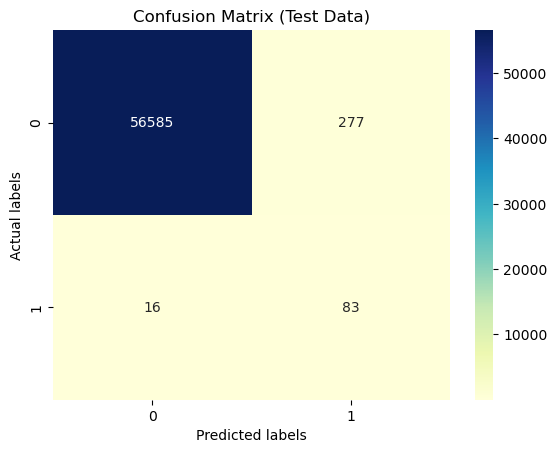

In [23]:
y_under = df_cc_balanced[cc_targ]
X_under = df_cc_balanced.drop(columns=cc_targ)

model_4 = LogisticRegression()
pipe_4 = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("model", model_4)
])

printAccuracies(pipe_4, X_under, y_under, df_cc_test_X, df_cc_test_y)

#### Oversampling

We can also take a random sample of the minority class, and then duplicate the records, so that we have a balanced dataset. This is also pretty simple, but we are duplicating records, which can lead to overfitting.

In [24]:
non_fraud_len = len(df_cc_train[df_cc_train["Class"] == 0])
fraud = df_cc_train[df_cc_train["Class"] == 1].sample(non_fraud_len, replace=True)

df_cc_balanced_over = pd.concat([df_cc_train[df_cc_train["Class"] == 0], fraud])

print("Counts:", df_cc_balanced_over["Class"].value_counts())
df_cc_balanced_over.head()

Counts: 0    227453
1    227453
Name: Class, dtype: int64


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
58402,-0.909543,0.913775,2.705236,3.341965,-1.374143,1.616072,-0.952857,0.828399,0.255903,0.209368,...,0.226647,1.059467,-0.123037,0.129858,-0.373434,0.420423,-0.093467,0.094171,44.35,0
273457,2.047859,-0.207376,-0.556358,0.172435,-0.304297,-0.429684,-0.401866,-0.107352,1.249762,-0.247968,...,-0.154777,-0.261259,0.258635,-0.691858,-0.247511,-0.885973,0.063825,-0.032184,1.00,0
240388,1.874117,-0.503700,-0.279750,0.521357,-0.469673,0.199991,-0.528157,0.113322,1.306867,-0.224749,...,-0.307679,-0.566847,0.292808,-0.397040,-0.318014,-0.653938,0.047869,-0.040497,35.69,0
124396,-11.475766,9.147341,-5.105455,-1.517102,-4.631355,-2.039495,-2.419711,3.857879,5.053754,8.855418,...,-1.118576,-1.211691,0.676269,0.547219,1.515326,-0.030714,0.558855,-0.551712,9.82,0
4984,-0.668847,0.192083,2.560111,-0.892411,-0.046207,-0.329043,0.503749,-0.405029,1.792504,-0.740261,...,-0.027076,0.579171,-0.241759,0.579289,-0.327490,0.835289,-0.455769,-0.311448,29.97,0


/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Results:
	Records:  454906
	True Records:  227453
	False Records:  227453


Testing Results:
	Records:  56961
	Testing accuracy: 97.88%
	Testing Precision: 6.77%
	Testing Recall: 87.88%
	Testing F1: 12.57%
	Total False Negatives: 6904
	Total False Positives: 53104
	False Negative Rate: 12.12%
	False Positive Rate: 93.23%

Confusion Matrix (Test Data):


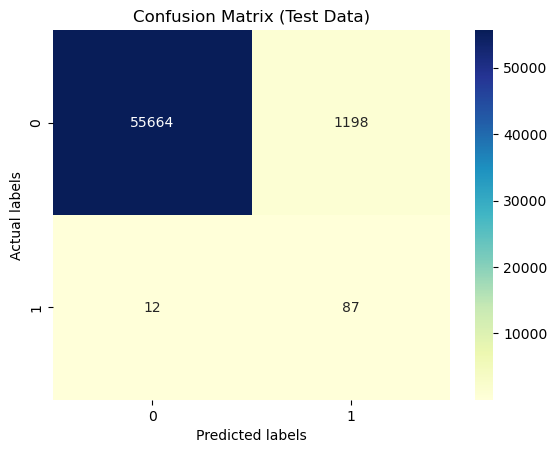

In [25]:
y_over = df_cc_balanced_over[cc_targ]
X_over = df_cc_balanced_over.drop(columns=cc_targ)


model_5 = LogisticRegression()
pipe_5 = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("model", model_5)
])

printAccuracies(pipe_5, X_over, y_over, df_cc_test_X, df_cc_test_y)

#### SMOTE

<b>Note:</b> this is an example of a technique to generate synthetic data, which is fairly common in machine learning. This is intended as an example only, the details are beyond the scope here. 

Synthetic Minority Over-sampling Technique (SMOTE) is a technique that creates synthetic data for the minority class. It does this by selecting two or more similar instances (using a distance measure) and creating a new instance that is a random linear combination of the two instances. This is a more complex technique, but it can be more effective than just oversampling the minority class. So, this technique will basically generate new data points to oversample the minority, rather than 'normal' oversampling, which just duplicates the existing data.

Training Results:
	Records:  454906
	True Records:  227453
	False Records:  227453


Testing Results:
	Records:  56961
	Testing accuracy: 98.47%
	Testing Precision: 9.13%
	Testing Recall: 86.87%
	Testing F1: 16.52%
	Total False Negatives: 7480
	Total False Positives: 51761
	False Negative Rate: 13.13%
	False Positive Rate: 90.87%

Confusion Matrix (Test Data):


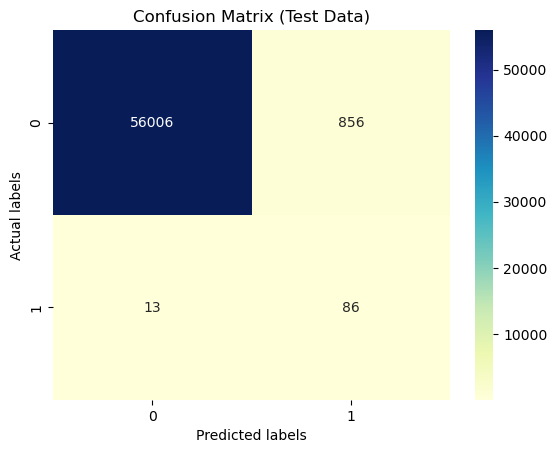

In [26]:
!pip install imblearn
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(df_cc_train.drop(columns=cc_targ), df_cc_train[cc_targ])

model_6 = LogisticRegression(max_iter=10000)
pipe_6 = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("model", model_6)
])

printAccuracies(pipe_6, X_smote, y_smote, df_cc_test_X, df_cc_test_y)

### Sampling and Imbalanced Results

This credit card dataset is <i>extremely</i> imbalanced, so it is a large challenge for any of our changes to overcome this massive skew in data. This is a fairly hard problem, at least for the types of tools we currently have in our toolkit. In addition to these techniques that we use to prepare data, there are other approaches that we can use to deal with imbalanced data, some of which we'll look at in the future.
<ul>
<li> Shift the decision boundary: we normally label a record as "1" if the probability is greater than 0.5, but we can capture the predicted probabilities, and use a different cutoff to make the prediction. </li>
<li> Pre-prime the model: some models can have a setting that takes in something like the baseline accuracy, and then adjusts the model to try to get a better balance. </li>
<li> Use a different model: some models are better at dealing with imbalanced data than others. </li>
<li> Use different hyperparameters: we can change the 'settings' that a model uses in its training to get better performance. </li>
</ul>

When we look at optimizing models, we'll look at some of these techniques in more detail.

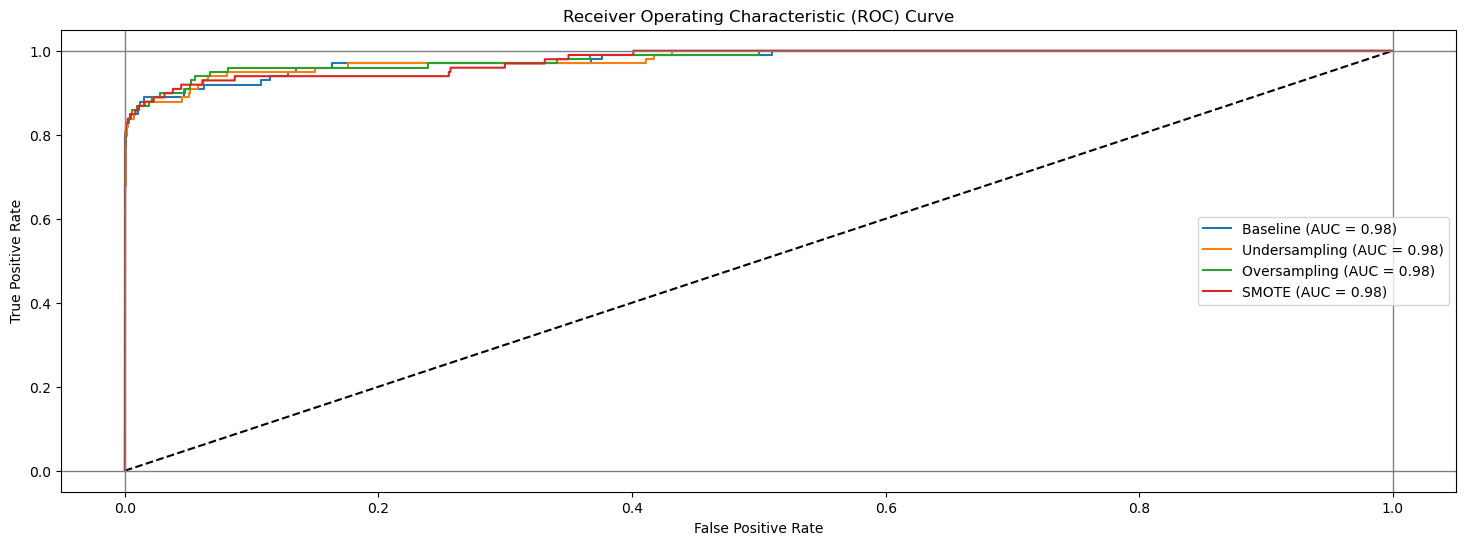

In [27]:
# Define the models and their names
models = [pipe_3, pipe_4, pipe_5, pipe_6]
model_names = ['Baseline', 'Undersampling', 'Oversampling', 'SMOTE']

# Create a figure and axes
fig, ax = plt.subplots(figsize=(18, 6))

# Plot the ROC curve for each model
for model, name in zip(models, model_names):
    y_pred_prob = model.predict_proba(df_cc_test_X)[:, 1]
    fpr, tpr, _ = roc_curve(df_cc_test_y, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
grid_color = "grey"
# Set the labels and title
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random classifier line
plt.axhline(y=0, color=grid_color, linewidth=1)
plt.axvline(x=0, color=grid_color, linewidth=1)
plt.axhline(y=1, color=grid_color, linewidth=1)
plt.axvline(x=1, color=grid_color, linewidth=1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')

# Add a legend
ax.legend()

# Show the plot
plt.show()


## Exercise

Use the dataset below to predict fraud. 

<b>Notes - Data Processing:</b>
<ul>
<li> This data has some columns that <i>might</i> be useful, but not in their current format. </li>
<li> There are some categories with many different values, and there are a few ways to deal with these, try to think of options. There isn't one specific, "right" answer. </li>
<li> Think of <i>what</i> value each column brings to the model. </li>
<li> There is both a simple challenge to do a classification, and a more complex challenge to transform some data into better features. (These transformations are a little more sophisticated, but they are realistic. Things like dates, times, and locations can likely be made into something more useful.) </li>
</ul>

This will require a little exploring and work to get things working. The logistic regression is simple, but we can restructure the data to hopefully benefit our model. 

In [28]:
filename = "fraudTrain.csv"
url = "https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/fraudTrain.csv"

if not os.path.isfile(filename):
    wget.download(url)

fraud_targ = "is_fraud"
df_fraud = pd.read_csv(filename)
df_fraud.drop(columns=["Unnamed: 0", "trans_date_trans_time", "trans_num", "cc_num",
                       "unix_time", "merch_lat", "merch_long", "lat", "long", "merchant", "street",
                       "first", "last", "city", "zip"
                       ], inplace=True)
df_fraud.head()

,category,amt,gender,state,city_pop,job,dob,is_fraud
0,misc_net,4.97,F,NC,3495,"Psychologist, counselling",1988-03-09,0
1,grocery_pos,107.23,F,WA,149,Special educational needs teacher,1978-06-21,0
2,entertainment,220.11,M,ID,4154,Nature conservation officer,1962-01-19,0
3,gas_transport,45.00,M,MT,1939,Patent attorney,1967-01-12,0
4,misc_pos,41.96,M,VA,99,Dance movement psychotherapist,1986-03-28,0


In [29]:
# Do it